In [1]:
"""
        SETUP ENVIRONMENT
"""
from enviroment import *
import gymnasium as gym
env = gym.make('CartPole-v1')
print("State dim:", env.observation_space.shape[0])
print("Action dim:", env.action_space.n)

State dim: 4
Action dim: 2


In [2]:
"""
        SETUP AGENT
"""
# REINFORCE
BETA1 = 0.1
BETA2 = 0.9
from try_grad_policy import PolicyNet
policy = PolicyNet(n_inputs = env.observation_space.shape[0], n_outputs= env.action_space.n, hidden_dim=128)  # Create a policy network$
policy.ntk_init(beta=BETA1)
ntk_policy = PolicyNet(n_inputs = env.observation_space.shape[0], n_outputs= env.action_space.n, hidden_dim=128)  # Create a policy with ntk parametrization
ntk_policy.ntk_init(beta=BETA2)
#ACTOR-CRITIC
from actor_critic import Actor, Critic
actor = Actor(env.observation_space.shape[0], env.action_space.n)
critic = Critic(env.observation_space.shape[0])

In [3]:
"""
        RUN EPISODES (NON TD)
"""
import torch

# Collect episodes using the current policy.
def run_episodes(policy, env, n_episodes=1):
    run = 0
    episodes = []
    while(run<n_episodes):
        episode = []
        truncated =  False
        terminated = False
        state = env.reset()
        state = state[0]
        while(not terminated):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            action = torch.multinomial(probs, num_samples=1).item()
            next_state, reward, terminated, truncated, info = run_env_step(env,action=action, random_action=False)
            episode.append((state, action, reward))
            state = next_state
        episodes.append(episode)
        run += 1
    return episodes

beta1 = 0.1    beta2 = 0.9
Episode 1
Loss: 39670.1107421875  and  693345.45


KeyboardInterrupt: 

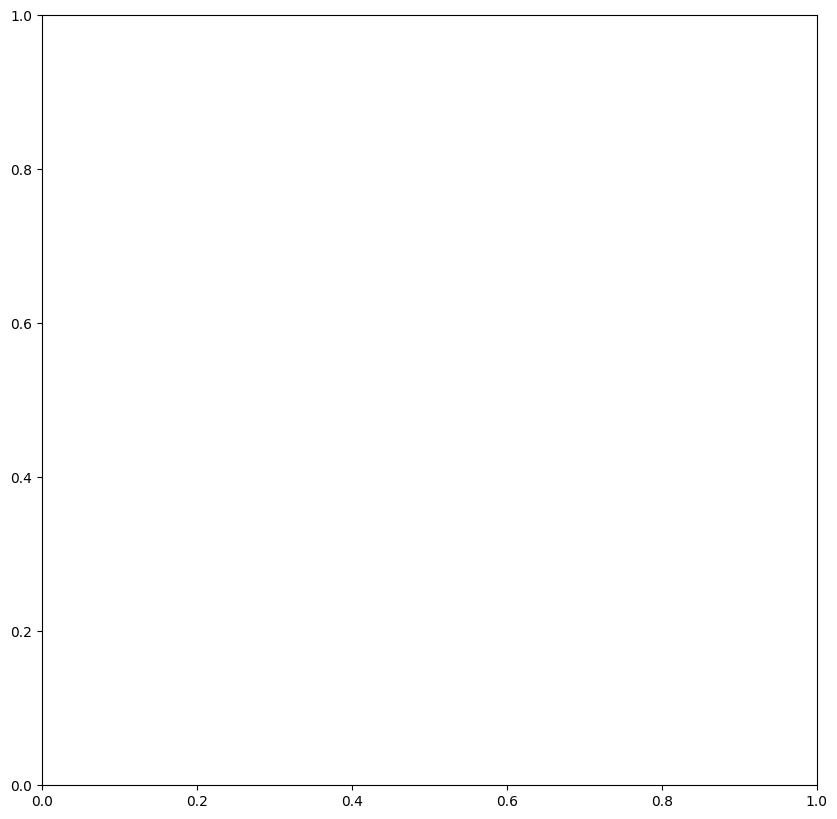

In [7]:
"""
        TRAINING (REINFORCE)
"""

LEARNING_RATE = 0.01
NUM_EPOCHES = 30
N_EPISODES = 5 # ^number of episodes per epoch
"""-------------------------------------------------------------------"""
import torch.optim as optim
from try_grad_policy import train_policy
import matplotlib.pyplot as plt
import multiprocessing

optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)  # Define the optimizer
optimizer_ntk = optim.Adam(ntk_policy.parameters(), lr=LEARNING_RATE)  # Define the optimizer
initialize_env(env)
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
loss_list = []
loss_ntk_list = []
# Train for a number of epochs
print(f"beta1 = {BETA1}    beta2 = {BETA2}")
for epoch in range(NUM_EPOCHES ):
    episodes = run_episodes(policy, env, n_episodes=N_EPISODES)  # Collect episodes
    episodes_ntk = run_episodes(ntk_policy, env, n_episodes=N_EPISODES)  # Collect episodes

    loss = train_policy(policy, optimizer, episodes)  # Update the policy based on the episodes
    loss_ntk = train_policy(ntk_policy, optimizer_ntk, episodes_ntk)  # Update the policy based on the episodes
    loss_list.append(loss)
    loss_ntk_list.append(loss_ntk)
    print(f"Episode {epoch + 1}")
    print(f'Loss: {loss}  and  {loss_ntk}')
close_env(env)
ax1.scatter(loss_list, label=f"{BETA1}")
ax1.scatter(loss_ntk_list, label=f"{BETA2}")
ax1.grid()
ax1.legend()


In [9]:
""" TEST AGENT"""
"-------------------TEST-------------------"
env = gym.make('CartPole-v1', render_mode = "human" )
run_episodes(policy, env, n_episodes=3)
close_env(env)
env = gym.make('CartPole-v1', render_mode = "human" )
run_episodes(ntk_policy, env, n_episodes=3)
close_env(env)

C:\Users\koq1231\PycharmProjects\RL\venv\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
"""
        TRAINING (REINFORCE)
"""

LEARNING_RATE = 0.01
NUM_EPOCHES = 30
N_EPISODES = 20 # ^number of episodes per epoch
"""-------------------------------------------------------------------"""
import torch.optim as optim
from try_grad_policy import train_policy
import multiprocessing

optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)  # Define the optimizer
optimizer_ntk = optim.Adam(ntk_policy.parameters(), lr=LEARNING_RATE)  # Define the optimizer


initialize_env(env)

output_queue1 = multiprocessing.Queue()
output_queue2 = multiprocessing.Queue()
run_process1 = multiprocessing.Process(target=run_episodes, args=(policy, env,output_queue1, N_EPISODES))
run_process2 = multiprocessing.Process(target=run_episodes, args=(ntk_policy, env,output_queue2, N_EPISODES))


# Train for a number of epochs
for epoch in range(NUM_EPOCHES ):
    run_process1.start()  # Collect episodes
    run_process2.start()
    # Join the processes to wait for them to finish
    run_process1.join()
    run_process2.join()
    # Get the outputs from both processes
    episodes = output_queue1.get()
    ntk_episodes = output_queue2.get()
    loss = train_policy(policy, optimizer, episodes)  # Update the policy based on the episodes
    ntk_loss = train_policy(ntk_policy, optimizer_ntk, ntk_episodes)  # Update the ntk_policy based on the episodes
    print(f'Episode {epoch + 1}, Total Loss: {BETA1}={loss} and {BETA2}={ntk_loss} ')
close_env(env)
"-------------------TEST-------------------"
env = gym.make('CartPole-v1', render_mode = "human" )
run_episodes(policy, env, n_episodes=10)

In [6]:
"""
        RUN EPISODES (TD)
"""
# We do online update at each step
import torch.optim as optim
actor_optimizer = optim.Adam(actor.parameters(), lr=0.01)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.01)
import numpy as np

def collect_and_update(actor,critic, env, n_episodes=10):
    run = 0
    gamma = 0.99
    rewards = []
    while(run<n_episodes):
        reward_ = 0
        truncated =  False
        terminated = False
        state = env.reset()
        state = state[0]
        while(not terminated):
            # Actor decides action
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = actor(state_tensor)
            action = torch.multinomial(probs, num_samples=1).item()

            # Take action in the environment
            next_state, reward, terminated, truncated, info = run_env_step(env,action=action, random_action=False)


            # Critic evaluates the action
            state_value = critic(state_tensor)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            next_state_value = critic(next_state_tensor)
            target = reward + gamma * next_state_value
            td_error = target - state_value


            # Update Critic
            critic_loss = td_error.pow(2)
            critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

            # Update Actor using the Advantage (TD Error)
            actor_loss = -torch.log(probs[0, action]) * td_error.detach()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            state = next_state
            reward_ += 1
        rewards.append(reward_)

        run += 1
    return np.mean(rewards)

In [ ]:
"""
        TRAINING (ACTOR-CRITIC)
"""
NUM_EPOCHES = 100
initialize_env(env)
# Train for a number of epochs
for epoch in range(NUM_EPOCHES):
    result=collect_and_update(actor,critic,env,10)
    print("Epoch: ", epoch, "Reward: ", result)
close_env(env)